In [7]:
import yfinance as yf  # yahoo finance 套件
import pandas as pd  # 結構化資料處理套件
import datetime as dt  # 時間套件
import matplotlib.pyplot as plt

In [8]:
# 輸入股票代號
stock_id = '2408.tw'
# stock_id = '2357.tw'
# stock_id = '2317.tw'
# stock_id = 'AAPL'
# stock_id = 'NVDA'

# --- 設定資料時間範圍 ---
# 方法一：從今天往回算特定天數
# 為什麼這樣設定？因為我們想要獲取最新的資料
'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
# start = end - dt.timedelta(days=180)

# 方法二：指定固定的時間區間（建議用這個，確保實驗可重現）
# 為什麼用固定時間？因為每天執行會得到不同資料，不利於比較實驗結果
'''抓取特定時間'''
start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2025, 10, 1)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()
# download() 函數會回傳一個 DataFrame，包含 Open, High, Low, Close, Volume等欄位

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)
print(stock_data.head())

/tmp/ipython-input-2922017640.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_id, start=start, end=end).reset_index()
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker        2408.TW    2408.TW    2408.TW    2408.TW   2408.TW
Date                                                            
2020-01-02  74.781815  77.999169  73.477481  73.912259  39909583
2020-01-03  73.738350  76.173103  72.694879  75.999194  18771916
2020-01-06  72.781830  73.651386  72.434013  73.042699   7741278
2020-01-07  70.520988  73.216611  69.564478  72.520970  16643874
2020-01-08  71.825325  73.564437  71.303593  71.738371  25273946


In [9]:
# 取得收盤價
# 為什麼只取收盤價？因為收盤價是最常用的股價指標，代表當天交易結束時的價格
# 如果要預測成交量，這裡改成 stock_data[['Volume']]
close_prices = stock_data[['Volume']]

# 1. **Transformer**
*   輸入連續 N 天的收盤價，只預測第 N+1 天的收盤價。
*   應用場景：適合需要逐日更新預測的策略，如每日交易決策




# 1.1 單步預測
輸入連續 N 天的收盤價，只預測第 N+1 天的收盤價。
應用場景：適合需要逐日更新預測的策略，如每日交易決策

## 1.1.1 **資料前處理**

In [10]:
# 資料集拆分
# 訓練資料集佔80%, 測試資料集佔20%
# 為什麼要拆分？因為需要用一部分資料訓練模型，另一部分資料測試模型效果
# 為什麼用 80/20 比例？這是業界常用的比例，確保有足夠的訓練資料，又保留足夠的測試資料
train_size = int(len(close_prices) * 0.8)
train_data = close_prices[:train_size]
test_data = close_prices[train_size:]

In [11]:
# 顯示訓練資料集和測試資料集的大小 (資料筆數, 特徵數)
print('訓練集形狀：', train_data.shape)
print('測試集形狀：', test_data.shape)

訓練集形狀： (1115, 1)
測試集形狀： (279, 1)


In [12]:
from sklearn.preprocessing import MinMaxScaler  # 正規化套件

# 為什麼要正規化？
# 1. 神經網路對數值範圍敏感，太大或太小的數值會導致訓練不穩定
# 2. 將所有特徵縮放到相同範圍（0-1），讓模型更容易學習
# 3. 加速訓練收斂速度
# 正規化數據（僅對訓練集進行 fit）
scaler = MinMaxScaler(feature_range=(0, 1))
# 為什麼只對訓練集 fit？
# 因為我們要模擬真實情況：模型只能看到訓練資料的統計特性
# 如果對整個資料集 fit，會造成「資料洩漏」(data leakage)，讓測試結果過於樂觀
train_data_scaled = scaler.fit_transform(train_data)
# 為什麼測試集只 transform？
# 使用訓練集學到的縮放參數（最小值、最大值）來轉換測試集
test_data_scaled = scaler.transform(test_data)

In [13]:
import numpy as np  # 數學運算套件

# 為什麼需要滑動窗口？
# 時間序列預測需要用「過去的資料」預測「未來的值」
# 例如：用第1-10天的股價預測第11天的股價，用第2-11天預測第12天，以此類推

# 設置輸入窗口
window_size = 30

# 構建訓練和測試數據集
def create_dataset(dataset, window_size):
    """
    建立滑動窗口資料集

    參數:
        dataset: 正規化後的資料 (numpy array)
        window_size: 窗口大小（要用幾天的歷史資料）

    回傳:
        X: 特徵資料（輸入），形狀為 (樣本數, window_size)
        y: 標籤資料（輸出），形狀為 (樣本數,)

    範例說明:
        假設 window_size = 3，資料為 [1, 2, 3, 4, 5]
        則會產生:
        X = [[1, 2, 3],    y = [4,
             [2, 3, 4]]         5]
    """
    X, y = [], [] # 初始化特徵和標籤的空列表
    # 滑動窗口
    # 為什麼是 len(dataset) - window_size？
    # 因為最後 window_size 筆資料無法產生完整的窗口
    # 例如：總共100筆，window_size=10，則只能產生90組訓練樣本
    for i in range(len(dataset) - window_size):
        # dataset[i:i + window_size, 0] 取出第 i 到 i+window_size 的資料作為輸入
        X.append(dataset[i:i + window_size, 0])
        # dataset[i + window_size, 0] 取出第 i+window_size 的資料作為輸出（要預測的值）
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)


# 訓練集和測試集
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)
print(f"\n滑動窗口處理後:")
print(f"X_train 原始形狀: {X_train.shape}")  # (樣本數, window_size)
print(f"y_train 形狀: {y_train.shape}")      # (樣本數,)
# 為了符合 Transformer 的輸入，重塑輸入為 (samples, time steps, features)
# 為什麼要 reshape？
# Transformer 模型的輸入要求是 3D 張量: (samples, time_steps, features)
# - samples: 有多少個訓練樣本
# - time_steps: 每個樣本的時間步數（這裡是 window_size）
# - features: 每個時間步有多少個特徵（這裡是 1，因為只有收盤價）
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f"X_train 重塑後形狀: {X_train.shape}")  # (樣本數, 時間步, 特徵數)
print(f"X_test 重塑後形狀: {X_test.shape}")


滑動窗口處理後:
X_train 原始形狀: (1085, 30)
y_train 形狀: (1085,)
X_train 重塑後形狀: (1085, 30, 1)
X_test 重塑後形狀: (249, 30, 1)


In [14]:
# 輸出訓練和測試數據集的形狀
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1085, 30, 1) (1085,) (249, 30, 1) (249,)


## ***1.1.2 建立 Transformer 模型***
目的：使用 Transformer 架構進行時間序列預測
為什麼用 Transformer？因為它能捕捉長距離依賴關係，比傳統 RNN/LSTM 更強

In [15]:
import tensorflow as tf  # TensorFlow 套件
from tensorflow.keras import layers  # 從 Keras 中引入 layers 以方便建立模型層

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Transformer 編碼器模塊

    這是 Transformer 的核心組件，包含兩個主要部分：
    1. Multi-Head Attention（多頭注意力機制）
    2. Feed Forward Network（前饋神經網路）

    為什麼需要這兩個部分？
    - Attention: 讓模型學習「哪些時間點的資料比較重要」
    - Feed Forward: 對每個時間點進行非線性轉換，增強表達能力

    參數說明:
        inputs: 輸入張量，形狀為 (batch_size, time_steps, features)
        head_size: 每個注意力頭的維度（控制模型的表達能力）
        num_heads: 注意力頭的數量（多個頭可以關注不同的模式）
        ff_dim: 前饋網路的隱藏層維度
        dropout: Dropout 比率（防止過擬合，隨機丟棄部分神經元）
        epsilon: Layer Normalization 用的小數值（避免除以0）
        attention_axes: 在哪個軸上做注意力（通常是時間軸）
        kernel_size: 卷積核大小
    """
    # === Part 1: Multi-Head Attention ===
    # 為什麼先做 Layer Normalization？
    # 穩定訓練過程，讓每一層的輸入分佈保持穩定
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)  # 正規化層
    # Multi-Head Attention 機制
    # 為什麼叫「多頭」？就像有多雙眼睛同時看資料，每雙眼睛關注不同的模式
    # 例如：頭1關注短期趨勢，頭2關注長期趨勢，頭3關注週期性模式
    x = layers.MultiHeadAttention(
        key_dim=head_size,  # 每個注意力頭的維度大小
        num_heads=num_heads,  # 有幾個注意力頭（建議是 features 的因數）
        dropout=dropout,  # 注意力權重的 dropout
        attention_axes=attention_axes
    )(x, x)  # 在時間軸上做注意力
    #自注意力：query, key, value 都來自同一個輸入

    # 為什麼要 Dropout？
    # 隨機丟棄一些神經元的輸出，迫使模型學習更魯棒的特徵，防止過度依賴特定神經元
    x = layers.Dropout(dropout)(x)  # Dropout 以防止過擬合

    # === Residual Connection（殘差連接）===
    # 為什麼要加回原始輸入？
    # 1. 解決深度網路的梯度消失問題（讓梯度更容易回傳）
    # 2. 保留原始資訊，避免訊息在傳遞過程中遺失
    # 3. 讓模型學習「變化量」而非「絕對值」，更容易訓練
    # 殘差連接 (Residual connection) 將注意力輸出與原始輸入相加
    res = x + inputs


    # === Part 2: Feed Forward Network ===
    # 為什麼需要前饋網路？
    # 注意力機制是線性轉換，前饋網路提供非線性，增強模型的表達能力
    # Feed Forward 部分
    x = layers.LayerNormalization(epsilon=epsilon)(res)  # 再次正規化
    # 第一層卷積：擴展維度（feature expansion）
    # 為什麼用 Conv1D 而不是 Dense？
    # Conv1D 可以在時間維度上共享參數，更適合時間序列；且計算效率更高
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(x)  # 卷積層 (第一層)，ReLU 激活函數
    x = layers.Dropout(dropout)(x)  # Dropout 以防止過擬合
    # 第二層卷積：壓縮回原始維度（feature compression）
    # 為什麼要壓縮回原始維度？為了和 residual connection 的形狀匹配
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)  # 卷積層 (第二層)，沒有激活函數

    # 再次使用 Residual Connection
    return x + res  # 殘差連接 (Residual connection) 將注意力輸出與原始輸入相加

def build_transfromer(window_size, head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    建立完整的 Transformer 模型

    模型架構:
    輸入 → [Transformer Block × N] → Global Average Pooling → MLP → 輸出

    為什麼這樣設計？
    1. 多個 Transformer Block 堆疊：提取更抽象、更高階的特徵
    2. Global Average Pooling：將時間序列壓縮成單一向量
    3. MLP：最終的決策層，將特徵映射到預測值

    參數說明:
        num_trans_blocks: 堆疊幾個 Transformer 編碼器（越多越深，但訓練越慢）
        mlp_units: MLP 各層的神經元數量列表，如 [128, 64] 表示兩層
        其他參數同 transformer_encoder
    """

    # 定義輸入張量的形狀
    # 這裡的數值為範例，可根據資料自行調整
    # window_size = 10  # 輸入的時間步數（要用幾天的歷史資料） # Removed hardcoded value
    n_outputs = 1     # 輸出的預測步數（單步預測就是1）
    n_features = 1    # 每個時間步的特徵數（這裡只有收盤價，所以是1）

    # 建立輸入層
    inputs = tf.keras.Input(shape=(window_size, n_features), name='Input')  # 建立輸入層
    x = inputs  # 初始化輸入

    # === 堆疊多個 Transformer 編碼器 ===
    # 為什麼要堆疊多層？
    # 就像 CNN 的多層卷積，淺層捕捉簡單模式，深層捕捉複雜模式
    # 第1層可能學到「昨天漲今天跌」，第2層可能學到「連續3天上漲後通常會回調」
    # 產生多個 Transformer 編碼器塊
    for _ in range(num_trans_blocks):
        x = transformer_encoder(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            attention_axes=attention_axes,
            kernel_size=kernel_size,
            epsilon=epsilon
        )

    # === Global Average Pooling ===
    # 為什麼要做池化？
    # 經過 Transformer 後，我們有 (batch_size, 10, 1) 的輸出
    # 但我們只需要預測1個數字，所以要把10個時間步「總結」成1個向量
    # Global Average Pooling 就是對所有時間步取平均
    # 全局平均池化層，用於壓縮時間步維度
    x = layers.GlobalAveragePooling1D()(x)

    # 多層感知器 (MLP)
    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)  # 全連接層，ReLU 激活函數
        x = layers.Dropout(mlp_dropout)(x)  # Dropout 以防止過擬合

    # 最終輸出層
    # 因為我們要預測的是股價（連續值），不需要激活函數的非線性轉換
    # 如果是分類問題（如漲跌預測），就需要用 sigmoid 或 softmax
    # 最終輸出層
    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs, name='one-step_prediction_transformer_encoder_model')  # 建立模型並返回模型

In [16]:
# 建立 Transfomer 模型
transformer_model = build_transfromer(
    window_size=window_size, # Pass the correct window_size
    head_size=128,        # 注意力頭的維度（越大模型越複雜）
    num_heads=4,          # 注意力頭的數量（建議是2的冪次）
    ff_dim=2,             # 前饋網路的維度（可以試試更大的值如128）
    num_trans_blocks=4,   # Transformer 層數（越多越深）
    mlp_units=[256],      # MLP 的隱藏層維度（可以是多層如 [256, 128]）
    mlp_dropout=0.10,     # MLP 的 dropout 比率
    dropout=0.10,         # Transformer 的 dropout 比率
    attention_axes=1      # 在時間軸（第1維）上做注意力
)
# === 編譯模型 ===
# 為什麼用 Adam 優化器？
# Adam 結合了 Momentum 和 RMSprop 的優點，是目前最常用的優化器
# 為什麼用 MSE 損失函數？
# 因為這是回歸問題，MSE 能衡量預測值和真實值的差距
transformer_model.compile(optimizer='adam', loss='mse') # 編譯模型
transformer_model.summary()

Model: "one-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 30, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 2)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 1)     │          3 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 1)     │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 1)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 2)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 1)     │          3 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 1)     │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_3[0][0]     

 Total params: 15,153 (59.19 KB)

 Trainable params: 15,153 (59.19 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# 訓練模型
hist = transformer_model.fit(
    X_train,              # 訓練特徵
    y_train,              # 訓練標籤
    epochs=25,            # 訓練輪數（可以增加到50-100，但訓練會更久）
    batch_size=32,        # 批次大小（越大訓練越快，但記憶體需求越大）
    validation_split=0.2, # 從訓練集切20%作為驗證集，監控過擬合
    verbose=1             # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - loss: 0.0297 - val_loss: 0.0189
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0119 - val_loss: 0.0185
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0116 - val_loss: 0.0190
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0096 - val_loss: 0.0185
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0110 - val_loss: 0.0185
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0105 - val_loss: 0.0191
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0125 - val_loss: 0.0186
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0109 - val_loss: 0.0186
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 0.0106 - val_loss: 0.0185
Epoch 10/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0120 - val_loss: 0.0190
Epoch 11/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0113 - val_loss: 0.0186
Epoch 12/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - lo

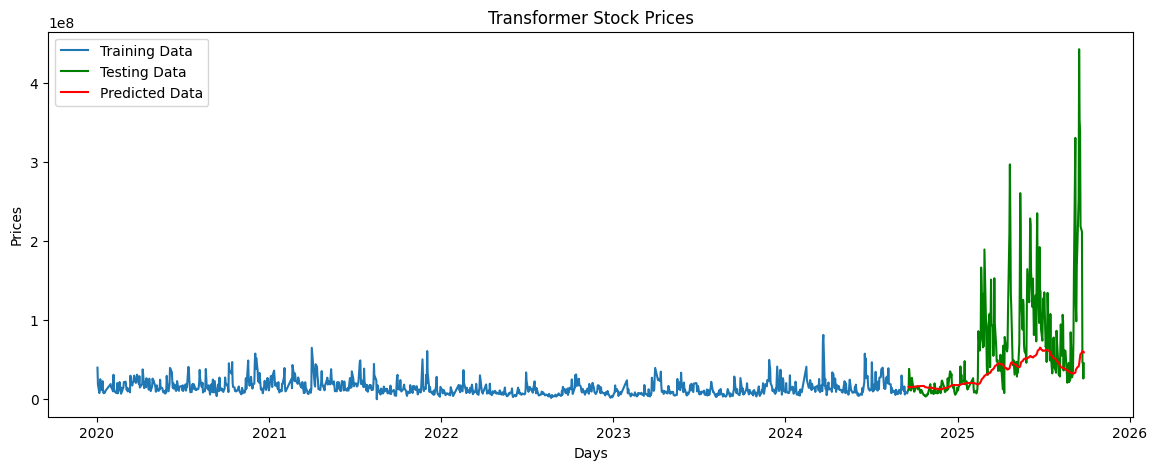

In [42]:
# 繪製整個資料集
plt.figure(figsize=(14, 5))
plt.plot(close_prices[:train_size + window_size],
         label='Training Data')  # 訓練集部分
plt.plot(close_prices[train_size + window_size:],
         label='Testing Data', color='green')  # 測試集部分
plt.plot(test_predict, label='Predicted Data', color='red')  # 預測部分
plt.title('Transformer Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [19]:
# 預測股價
y_pred = transformer_model.predict(X_test)
# === 反正規化 ===
# 為什麼要反正規化？
# 預測值是 0-1 之間的數字，我們要轉換回實際的股價，方便理解和比較
# 反正規化預測值 (0~1 -> 實際值)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
# 預測值轉為 DataFrame 格式
test_predict = pd.DataFrame(
    y_pred, columns=['Predicted'], index=test_data[window_size:].index)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


In [20]:
mse = transformer_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3406
Mean Squared Error: 0.7581145167350769


In [61]:
# 訓練模型
hist = transformer_model.fit(
    X_train,              # 訓練特徵
    y_train,              # 訓練標籤
    epochs=25,            # 訓練輪數（可以增加到50-100，但訓練會更久）
    batch_size=32,        # 批次大小（越大訓練越快，但記憶體需求越大）
    validation_split=0.2, # 從訓練集切20%作為驗證集，監控過擬合
    verbose=1             # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0113 - val_loss: 0.0193
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0097 - val_loss: 0.0188
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0114 - val_loss: 0.0191
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0104 - val_loss: 0.0189
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0117 - val_loss: 0.0188
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0113 - val_loss: 0.0188
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0113 - val_loss: 0.0194
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0101 - val_loss: 0.0196
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0116 - val_loss: 0.0190
Epoch 10/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0101 - val_loss: 0.0189
Epoch 11/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0092 - val_loss: 0.0194
Epoch 12/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 

In [21]:
mse = transformer_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.3406
Mean Squared Error: 0.7581145167350769


1.1.3 **結果評估**

In [22]:
# 預測股價
y_pred = transformer_model.predict(X_test)
# === 反正規化 ===
# 為什麼要反正規化？
# 預測值是 0-1 之間的數字，我們要轉換回實際的股價，方便理解和比較
# 反正規化預測值 (0~1 -> 實際值)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
# 預測值轉為 DataFrame 格式
test_predict = pd.DataFrame(
    y_pred, columns=['Predicted'], index=test_data[window_size:].index)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


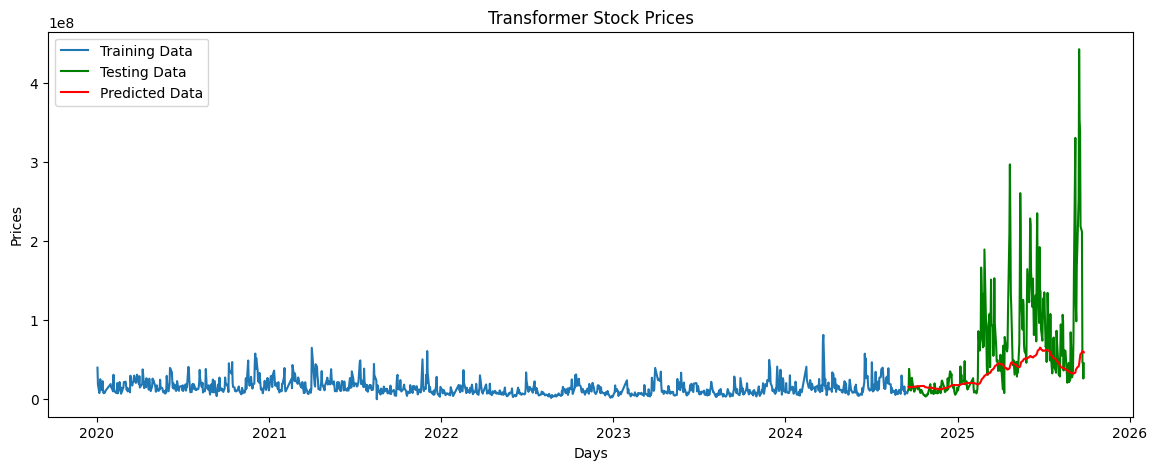

In [23]:
# 繪製整個資料集
plt.figure(figsize=(14, 5))
plt.plot(close_prices[:train_size + window_size],
         label='Training Data')  # 訓練集部分
plt.plot(close_prices[train_size + window_size:],
         label='Testing Data', color='green')  # 測試集部分
plt.plot(test_predict, label='Predicted Data', color='red')  # 預測部分
plt.title('Transformer Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

# 1.2 **多步預測**

1.2.1 **資料前處理**

In [24]:
import numpy as np  # 數學運算套件

# === 設定多步預測參數 ===
window_size = 30  # 輸入20天的歷史資料
n_outputs = 30    # 預測未來20天的股價

print(f"輸入窗口大小: {window_size} 天")
print(f"預測步數: {n_outputs} 天")

# 構建訓練和測試數據集，加入預測步數
def create_dataset(dataset, window_size, n_outputs):
    """
    建立多步預測的滑動窗口資料集

    與單步預測的差異：
    - 單步: y 是單一數值
    - 多步: y 是一個向量（包含未來 n_outputs 天的值）

    範例:
        window_size=3, n_outputs=2, 資料=[1,2,3,4,5,6]
        X = [[1,2,3],    y = [[4,5],
             [2,3,4]]         [5,6]]
    """

    X, y = [], []
    # 滑動窗口
    # 為什麼是 len(dataset) - window_size - n_outputs + 1？
    # 因為我們需要同時保留「輸入窗口」和「輸出窗口」的完整資料
    for i in range(len(dataset) - window_size - n_outputs + 1):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size:i + window_size + n_outputs, 0])
    return np.array(X), np.array(y)

# 建立多步預測的訓練集和測試集
X_train, y_train = create_dataset(train_data_scaled, window_size, n_outputs)
X_test, y_test = create_dataset(test_data_scaled, window_size, n_outputs)

# 為了符合 Transformer 的輸入，重塑輸入為 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

輸入窗口大小: 30 天
預測步數: 30 天


In [25]:
# 輸出訓練和測試數據集的形狀
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1056, 30, 1) (1056, 30) (220, 30, 1) (220, 30)


1.2.2 建立 Transformer **模型**

In [32]:
import tensorflow as tf  # TensorFlow 套件
from tensorflow.keras import layers  # 從 Keras 中引入 layers 以方便建立模型層

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    '''
    單一的 Transformer 編碼器魔塊。


    回傳:
    - 編碼器塊處理後的張量。
    '''

    """
    建立多步預測的 Transformer 模型

    與單步預測的差異：
    - 輸出層的神經元數量從 1 改為 n_outputs
    - 模型會同時輸出未來 n_outputs 天的預測值

    為什麼可以這樣做？
    模型會學習「給定過去20天，未來20天的整體趨勢」
    這比「逐天預測20次」更有效率，且能考慮未來各天之間的相關性
    """

    x = layers.LayerNormalization(epsilon=epsilon)(inputs)  # 正規化層
    # 多頭注意力機制
    x = layers.MultiHeadAttention(
        key_dim=head_size,  # 注意力頭的維度大小
        num_heads=num_heads,  # 注意力頭的數量
        dropout=dropout,  # Dropout 的比率
        attention_axes=attention_axes
    )(x, x)  # 自注意力機制，q, k, v 均來自於 x 本身
    x = layers.Dropout(dropout)(x)  # Dropout 以防止過擬合
    # 殘差連接 (Residual connection) 將注意力輸出與原始輸入相加
    res = x + inputs

    # Feed Forward 部分
    x = layers.LayerNormalization(epsilon=epsilon)(res)  # 正規化層
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(x)  # 卷積層 (第一層)，ReLU 激活函數
    x = layers.Dropout(dropout)(x)  # Dropout 以防止過擬合
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)  # 卷積層 (第二層)，沒有激活函數
    return x + res  # 殘差連接 (Residual connection) 將注意力輸出與原始輸入相加

def build_transfromer(window_size, n_outputs, head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    建立多步預測的 Transformer 模型

    與單步預測的差異：
    - 輸出層的神經元數量從 1 改為 n_outputs
    - 模型會同時輸出未來 n_outputs 天的預測值

    為什麼可以這樣做？
    模型會學習「給定過去20天，未來20天的整體趨勢」
    這比「逐天預測20次」更有效率，且能考慮未來各天之間的相關性

    參數:
    - window_size: 輸入窗口大小
    - n_outputs: 預測步數
    - head_size: 每個注意力頭的維度大小。
    - num_heads: 注意力頭的數量。
    - ff_dim: 前饋神經網路的維度大小。
    - num_trans_blocks: Transformer 編碼器塊的數量。
    - mlp_units: MLP 的全連接層單元數列表。
    - dropout: 編碼器塊內的 Dropout 比率，用於防止過擬合。
    - mlp_dropout: MLP 層的 Dropout 比率。
    - attention_axes: 指定多頭注意力機制的軸向（例如時間軸）。
    - epsilon: 用於層正規化的微小數值，避免除以 0 的情況。
    - kernel_size: 1D 卷積的卷積核大小。

    """
    # 定義輸入張量的形狀
    # window_size, n_outputs, n_features = 20, 20, 1  # 這裡的數值為範例，可根據資料自行調整
    n_features = 1 # 每個時間步的特徵數（這裡只有收盤價，所以是1）

    inputs = tf.keras.Input(shape=(window_size, n_features), name='Input')  # 建立輸入層
    x = inputs  # 初始化輸入

    # 產生多個 Transformer 編碼器塊
    for _ in range(num_trans_blocks):
        x = transformer_encoder(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            attention_axes=attention_axes,
            kernel_size=kernel_size,
            epsilon=epsilon
        )

    # 全局平均池化層，用於壓縮時間步維度
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Reshape layer to remove the last dimension if it's 1
    if n_features == 1:
        # Use Reshape layer instead of tf.squeeze
        x = layers.Reshape((-1,))(x)


    # 多層感知器 (MLP)
    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)  # 全連接層，ReLU 激活函數
        x = layers.Dropout(mlp_dropout)(x)  # Dropout 以防止過擬合

    # 最終輸出層
    # 輸出層：注意這裡輸出 n_outputs 個神經元
    # 每個神經元對應未來某一天的預測值
    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs, name='multi-step_prediction_transformer_encoder_model')  # 建立模型並返回模型

In [40]:
# 建立 Transfomer 模型
transformer_model = build_transfromer(window_size=window_size, n_outputs=n_outputs, head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer_model.compile(optimizer='adam', loss='mse') # 編譯模型
transformer_model.summary()

Model: "multi-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 30, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_76          │ (None, 30, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 30, 1)     │          0 │ dropout_76[0][0], │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_48[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_77          │ (None, 30, 2)     │          0 │ conv1d_48[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 30, 1)     │          3 │ dropout_77[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_49 (Add)        │ (None, 30, 1)     │          0 │ conv1d_49[0][0],  │
│                     │                   │            │ add_48[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_49[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 30, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, 30, 1)     │          0 │ dropout_79[0][0], │
│                     │                   │            │ add_49[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_50[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 30, 2)     │          0 │ conv1d_50[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 30, 1)     │          3 │ dropout_80[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 22,606 (88.30 KB)

 Trainable params: 22,606 (88.30 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# 評估測試集
mse = transformer_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3288
Mean Squared Error: 0.5544116497039795


In [34]:
# 訓練模型
hist = transformer_model.fit(
    X_train,  # 特徵
    y_train,  # 標籤
    epochs=25,  # 訓練次數
    batch_size=32,  # 批次大小
    validation_split=0.2,  # 驗證集比例
    verbose=1  # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - loss: 0.0323 - val_loss: 0.0203
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0128 - val_loss: 0.0190
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0121 - val_loss: 0.0190
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0118 - val_loss: 0.0198
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0125 - val_loss: 0.0197
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0118 - val_loss: 0.0190
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0117 - val_loss: 0.0193
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0117 - val_loss: 0.0191
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0120 - val_loss: 0.0191
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0118 - val_loss: 0.0197
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0114 - val_loss: 0.0201
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - l

In [33]:
# 建立 Transfomer 模型
transformer_model = build_transfromer(window_size=window_size, n_outputs=n_outputs, head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer_model.compile(optimizer='adam', loss='mse') # 編譯模型
transformer_model.summary()

Model: "multi-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 30, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 30, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 30, 1)     │          0 │ dropout_50[0][0], │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 30, 2)     │          0 │ conv1d_32[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 30, 1)     │          3 │ dropout_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 30, 1)     │          0 │ conv1d_33[0][0],  │
│                     │                   │            │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 30, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 30, 1)     │          0 │ dropout_53[0][0], │
│                     │                   │            │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 30, 2)     │          0 │ conv1d_34[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 30, 1)     │          3 │ dropout_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 22,606 (88.30 KB)

 Trainable params: 22,606 (88.30 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# 建立 Transfomer 模型
transformer_model = build_transfromer(window_size=window_size, n_outputs=n_outputs, head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer_model.compile(optimizer='adam', loss='mse') # 編譯模型
transformer_model.summary()

Model: "multi-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 30, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_89          │ (None, 30, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 30, 1)     │          0 │ dropout_89[0][0], │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_56[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 30, 2)     │          0 │ conv1d_56[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 30, 1)     │          3 │ dropout_90[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 30, 1)     │          0 │ conv1d_57[0][0],  │
│                     │                   │            │ add_56[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_57[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 30, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_58 (Add)        │ (None, 30, 1)     │          0 │ dropout_92[0][0], │
│                     │                   │            │ add_57[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_58[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_93          │ (None, 30, 2)     │          0 │ conv1d_58[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 30, 1)     │          3 │ dropout_93[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 22,606 (88.30 KB)

 Trainable params: 22,606 (88.30 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# 建立 Transfomer 模型
transformer_model = build_transfromer(window_size=window_size, n_outputs=n_outputs, head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer_model.compile(optimizer='adam', loss='mse') # 編譯模型
transformer_model.summary()

Model: "multi-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 30, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 30, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 30, 1)     │          0 │ dropout_63[0][0], │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_40[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 30, 2)     │          0 │ conv1d_40[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 30, 1)     │          3 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 30, 1)     │          0 │ conv1d_41[0][0],  │
│                     │                   │            │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_41[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 30, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 30, 1)     │          0 │ dropout_66[0][0], │
│                     │                   │            │ add_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_42[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 30, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 30, 2)     │          0 │ conv1d_42[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 30, 1)     │          3 │ dropout_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 22,606 (88.30 KB)

 Trainable params: 22,606 (88.30 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# 訓練模型
hist = transformer_model.fit(
    X_train,  # 特徵
    y_train,  # 標籤
    epochs=25,  # 訓練次數
    batch_size=32,  # 批次大小
    validation_split=0.2,  # 驗證集比例
    verbose=1  # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0110 - val_loss: 0.0209
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0113 - val_loss: 0.0207
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0109 - val_loss: 0.0212
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0106 - val_loss: 0.0209
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0109 - val_loss: 0.0210
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0112 - val_loss: 0.0209
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0111 - val_loss: 0.0212
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0108 - val_loss: 0.0206
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0106 - val_loss: 0.0206
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0110 - val_loss: 0.0208
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0108 - val_loss: 0.0209
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss

1.2.3 **結果評估**

In [ ]:
# 評估測試集
mse = transformer_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

In [37]:
# 訓練模型
hist = transformer_model.fit(
    X_train,  # 特徵
    y_train,  # 標籤
    epochs=25,  # 訓練次數
    batch_size=32,  # 批次大小
    validation_split=0.2,  # 驗證集比例
    verbose=1  # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0109 - val_loss: 0.0204
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0110 - val_loss: 0.0208
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0104 - val_loss: 0.0201
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0108 - val_loss: 0.0205
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0113 - val_loss: 0.0206
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0110 - val_loss: 0.0204
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0111 - val_loss: 0.0205
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0110 - val_loss: 0.0202
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0110 - val_loss: 0.0204
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0110 - val_loss: 0.0203
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0106 - val_loss: 0.0207
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - lo

In [36]:
from sklearn.metrics import mean_squared_error  # 均方誤差
# 為什麼要分別繪製每一天？
# 因為每一天的預測難度不同：
# - 第1天：相對容易，資訊較新
# - 第10天：中等難度
# - 第20天：最困難，離輸入資料最遠
# 分開繪製可以清楚看出預測品質隨時間的衰減

# Define test_true
test_true = scaler.inverse_transform(y_test)

# Predict on the test set
y_pred = transformer_model.predict(X_test)
# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)


for i in range(n_outputs):
    plt.figure(figsize=(14, 5))
    test_true_df = pd.DataFrame(
        test_true[:, i], columns=['Actual'], index=test_data.index[window_size:window_size+len(test_true)])
    test_predict_df = pd.DataFrame(
        y_pred[:, i], columns=['Predicted'], index=test_data.index[window_size:window_size+len(y_pred)])
    plt.plot(test_true_df, label='Actual Data')  # 畫出實際數據
    plt.plot(test_predict_df, label='Predicted Data')  # 畫出預測數據
    plt.title(f'Transformer Stock Prices Prediction day-{i + 1}')
    plt.xlabel('Days')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()
    mse = mean_squared_error(test_true[:, i], y_pred[:, i])
    print(f'Day {i + 1} MSE:', mse)
    print()

Output hidden; open in https://colab.research.google.com to view.